In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

Business Case: What price should a cafe's items be sold for to optimize sales.

# Obtain

In [2]:
# Load the dataset
data_path = "cafe_pricing.csv"
df = pd.read_csv(data_path)
df.head()

,Date,Day of Week,Time of Day,Menu Item,Price ($),Units Sold,Competitor Price ($),Customer Type,Weather,Holiday,Special Promotion,Profit Margin ($),Daily Sales ($)
0,2022-01-01,Sunday,Morning,Tea,2.80,65,5.72,Loyal,Cloudy,No,NaN,0.58,182.00
1,2022-01-02,Thursday,Morning,Tea,5.98,32,4.70,New,Sunny,No,Buy 1 Get 1,4.79,191.36
2,2022-01-03,Friday,Afternoon,Tea,2.36,20,3.23,Loyal,Cloudy,Yes,NaN,1.33,47.20
3,2022-01-04,Sunday,Evening,Smoothie,2.01,73,3.48,New,Rainy,No,Buy 1 Get 1,-0.02,146.73
4,2022-01-05,Wednesday,Morning,croissant,2.18,17,4.20,Loyal,Sunny,Yes,NaN,0.73,37.06


# Scrub

In [3]:
# Make season feature 
# Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Create the 'season' column
df['season'] = df['Date'].dt.month.apply(get_season)

In [4]:
# Clean column names
df.columns = ['date', 'day_of_week', 'time_of_day', 'menu_item', 'price',
       'yesterday_units_sold', 'competitor_price', 'customer_type', 'weather',
       'holiday', 'special_promotion', 'profit_margin', 'daily_sales',
       'season']

In [5]:
# Clean Menu Item
df['menu_item'].unique()

array(['Tea', 'Smoothie', 'croissant', 'Coffee', 'Cup Cake', 'Cupcake',
       'Croissant'], dtype=object)

In [6]:
# Combine croissant items
df['menu_item'] = df['menu_item'].str.replace('croissant', 'Croissant')

# Combine Cupcakee items 
df['menu_item'] = df['menu_item'].str.replace('Cup Cake', 'Cupcake')

# Verify results
df['menu_item'].unique()

array(['Tea', 'Smoothie', 'Croissant', 'Coffee', 'Cupcake'], dtype=object)

In [7]:
# Drop the column 'profit margin' due to data linkage
df = df.drop(['profit_margin'], axis=1)

# Explore 

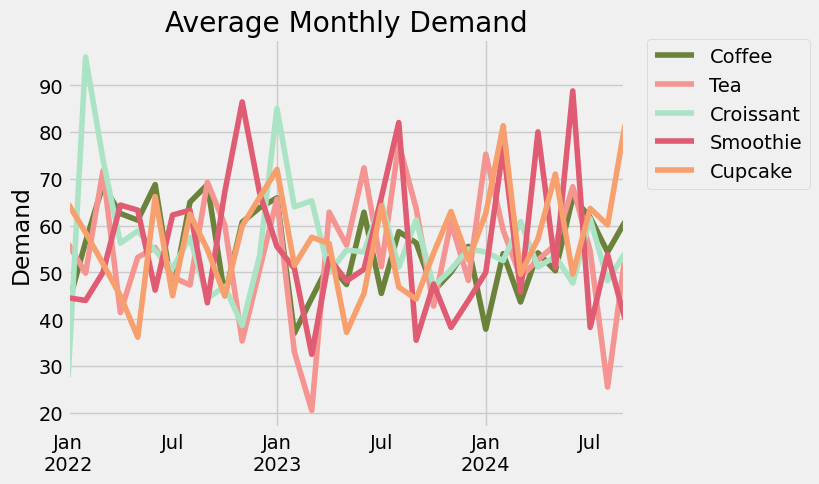

In [8]:
with plt.style.context('fivethirtyeight'):
    df[(df['menu_item'] == 'Coffee')].set_index('date').resample('M')['yesterday_units_sold'].mean().plot(
        kind='line', label='Coffee', color='#6a823a')
    df[(df['menu_item'] == 'Tea')].set_index('date').resample('M')['yesterday_units_sold'].mean().plot(
        kind='line', label='Tea', color='#f59592')
    df[(df['menu_item'] == 'Croissant')].set_index('date').resample('M')['yesterday_units_sold'].mean().plot(
        kind='line', label='Croissant', color='#abe4c5')
    df[(df['menu_item'] == 'Smoothie')].set_index('date').resample('M')['yesterday_units_sold'].mean().plot(
        kind='line', label='Smoothie', color='#df5c72')
    df[(df['menu_item'] == 'Cupcake')].set_index('date').resample('M')['yesterday_units_sold'].mean().plot(
        kind='line', label='Cupcake', color='#f7a06d')
    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    plt.xlabel('')
    plt.ylabel('Demand')
    plt.title('Average Monthly Demand')
    plt.show()

Shows no clear trends in average monthly demand of products

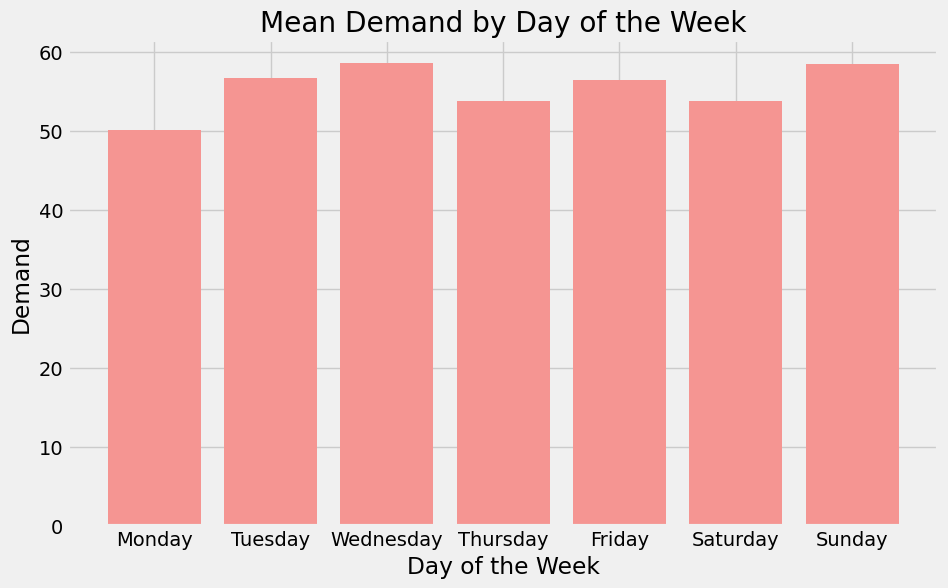

In [9]:
# day of week vs demand 
# Extract the day of the week (e.g., 'Monday', 'Tuesday')
df['day_of_week'] = df['date'].dt.day_name()

# Define the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by day of the week and calculate the mean of the 'value' column
mean_values = df.groupby('day_of_week')['yesterday_units_sold'].mean()

# Sort the mean values by the day of the week using the custom order
mean_values = mean_values[day_order]

# Create the bar plot
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10, 6))
    plt.bar(mean_values.index, mean_values.values, color='#f59592')
    plt.xlabel('Day of the Week')
    plt.ylabel('Demand')
    plt.title('Mean Demand by Day of the Week')
    plt.show()

Small fluctuations by day of week 

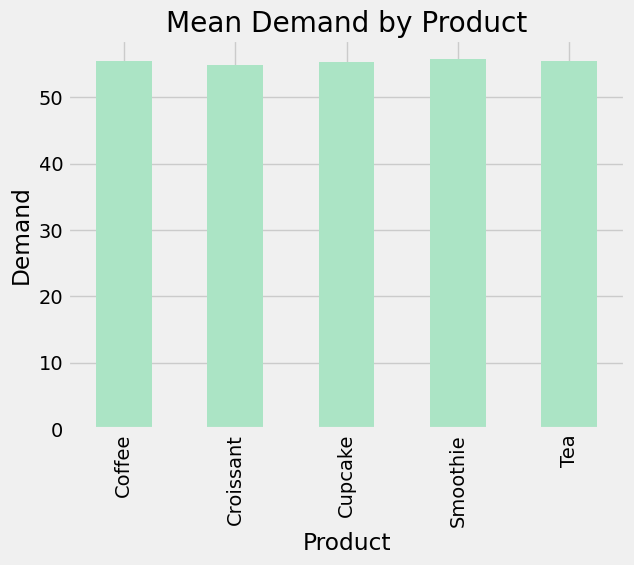

In [10]:
# demand by product 

with plt.style.context('fivethirtyeight'):
    df.groupby('menu_item')['yesterday_units_sold'].mean().plot(kind='bar', color='#abe4c5')
    plt.ylabel('Demand')
    plt.xlabel('Product')
    plt.title('Mean Demand by Product')
    plt.show()

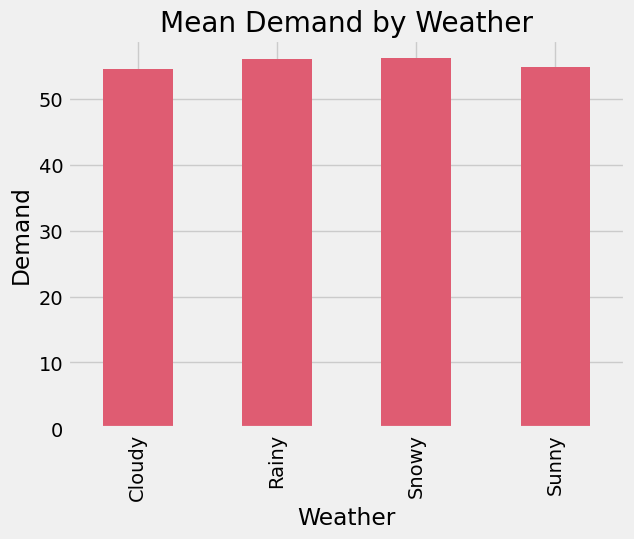

In [11]:
# demand by weather

with plt.style.context('fivethirtyeight'):
    df.groupby('weather')['yesterday_units_sold'].mean().plot(kind='bar', color='#df5c72')
    plt.ylabel('Demand')
    plt.xlabel('Weather')
    plt.title('Mean Demand by Weather')
    plt.show()

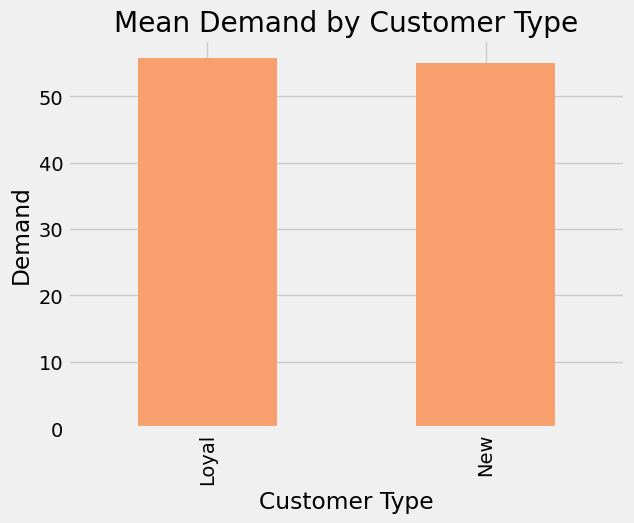

In [12]:
# demand by customer type 

with plt.style.context('fivethirtyeight'):
    df.groupby('customer_type')['yesterday_units_sold'].mean().plot(kind='bar', color='#f7a06d')
    plt.ylabel('Demand')
    plt.xlabel('Customer Type')
    plt.title('Mean Demand by Customer Type')
    plt.show()

# Model


In [13]:
# dummy encode categorical variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1000 non-null   datetime64[ns]
 1   day_of_week           1000 non-null   object        
 2   time_of_day           1000 non-null   object        
 3   menu_item             1000 non-null   object        
 4   price                 1000 non-null   float64       
 5   yesterday_units_sold  1000 non-null   int64         
 6   competitor_price      1000 non-null   float64       
 7   customer_type         1000 non-null   object        
 8   weather               1000 non-null   object        
 9   holiday               1000 non-null   object        
 10  special_promotion     652 non-null    object        
 11  daily_sales           1000 non-null   float64       
 12  season                1000 non-null   object        
dtypes: datetime64[ns](1

In [14]:
# Encode categorical variables
df_dummy = pd.get_dummies(df, columns = [
    'day_of_week', 'time_of_day', 'menu_item', 'customer_type', 'weather', 'holiday', 'special_promotion', 'season'
], drop_first=True)

df_dummy = df_dummy.drop(columns=['date', 'daily_sales'], errors='ignore')

In [15]:
# Define features and target variable
X = df_dummy.drop(columns=['price'])
y = df_dummy['price']

In [16]:
# Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Train a pricing model with Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [18]:
# Make predictions
y_pred = model.predict(X_test)

In [19]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 1.32


# Interpret

In [20]:
# Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importance)


Feature Importances:
competitor_price                  0.283445
yesterday_units_sold              0.228615
special_promotion_Discount 10%    0.031539
time_of_day_Evening               0.029265
customer_type_New                 0.029067
holiday_Yes                       0.028223
season_Spring                     0.024571
weather_Rainy                     0.024428
menu_item_Cupcake                 0.024330
time_of_day_Morning               0.023781
weather_Snowy                     0.023100
menu_item_Tea                     0.022757
season_Winter                     0.022711
day_of_week_Sunday                0.022533
day_of_week_Saturday              0.022101
weather_Sunny                     0.021915
menu_item_Croissant               0.021486
season_Summer                     0.021296
day_of_week_Thursday              0.021035
day_of_week_Monday                0.020426
menu_item_Smoothie                0.018587
day_of_week_Wednesday             0.017969
day_of_week_Tuesday             

In [21]:
# Example: Predicting optimal price for a new scenario
new_data = {
    'yesterday_units_sold': [50],
    'competitor_price': [3.75],
    'day_of_week_Monday': [1],
    'day_of_week_Saturday': [0],
    'day_of_week_Sunday': [0],
    'day_of_week_Thursday': [0],
    'day_of_week_Tuesday': [0],
    'day_of_week_Wednesday': [0],
    'time_of_day_Evening': [0],
    'time_of_day_Morning': [1],
    'menu_item_Croissant': [1],
    'menu_item_Cupcake': [0],
    'menu_item_Smoothie': [0],
    'menu_item_Tea': [0],
    'customer_type_New': [1],
    'weather_Rainy': [0],
    'weather_Snowy': [0],
    'weather_Sunny': [1],
    'holiday_Yes': [0],
    'special_promotion_Discount 10%': [1],
    'season_Spring': [1],
    'season_Summer': [0],
    'season_Winter': [0]
}

In [22]:
new_data_df = pd.DataFrame(new_data)

In [23]:
optimal_price = model.predict(new_data_df)
print(f"\nPredicted Optimal Price for the New Scenario: ${optimal_price[0]:.2f}")


Predicted Optimal Price for the New Scenario: $4.07
